In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

%load_ext autoreload
%autoreload 1
%aimport atfml
%aimport atfml.bundles

In [2]:
import numpy as np
from collections import Counter

# https://cs.stanford.edu/people/karpathy/char-rnn/warpeace_input.txt
def build_leo_tolstoy_dataset(path='/home/usman/data/char_lstm/warpeace_input.txt', 
                              n_data = 10000, window=10, batch_size=100):
    with open(path) as file:
        string = (''.join([next(file) for x in range(n_data)]))[1:].replace('\n', ' ')
    charset = list(zip(*Counter(string).most_common(70)))[0]
    ch_idx = lambda ch: charset.index(ch) + 1 if ch in charset else 0
    X_list, y_list = [], []
    for substr, target_char in [(string[i:i+window], string[i+window]) for i in range(n_data)]:
        x_row = [ch_idx(char) for char in substr]
        y = ch_idx(target_char)
        X_list.append(x_row)
        y_list.append(y)
    n_batches = int(n_data/batch_size)
    X = np.array(X_list)[:n_batches*batch_size]
    y = np.array(y_list)[:n_batches*batch_size]
    
    return ([{'X': X_batch, 'y': y_batch} 
            for X_batch, y_batch 
            in zip(np.split(X, n_batches, axis=0), 
                   np.split(y, n_batches, axis=0))], 
            
            {'charset_size': len(charset), 
             'mapping': dict(zip(charset, range(len(charset)))),
             'back_mapping': dict(zip(range(len(charset)), charset))}
           )

def prediction_into_string(pred, data_spec, err = '#'):
    if err in data_spec['mapping'].keys():
        raise ValueError('Wow, change err, it should not be in the mapping')
    
    bm = data_spec['back_mapping']
    return ''.join([(bm[n-1] if n > 0 else err) for n in pred.tolist()])

### Implementation without unit bundles (explicit one):

Using gpu device 2: Tesla K40c (CNMeM is disabled, cuDNN 4007)
/home/usman/anaconda2/envs/autograd_py3/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Weight shapes are: {'E': (70, 100), 'b_f': (100,), 'b_c': (100,), 'b_o': (100,), 'V_c': (100, 100), 'W_f': (200, 100), 'W_i': (200, 100), 'W_c': (200, 100), 'b_i': (100,), 'W_o': (200, 100), 'h_0': (100,), 'c_0': (100,)}, n_total_params: 97600
FAST_COMPILE
Building learning step function and gradient .... done
Building  loss.. done
Building  score.. done
Building  predict.. done
Charset:  70
0        499       0.19
>> t I warn you, if you don't tel | ss8onatatatatatatatatatatatatatatatatatatatatatata
50      278.8       0.23
>>  or Haugwitz either. This famo | the hat has have haveres and the has the has the h
100      225.5        0.4
>> ell, Prince, so Genoa and Lucc | e said the was the was the was the was the was the
150      245.6       0.31
>>  And I don't believe a word th | e of the of the of the of the of the of the of the
200      202.9       0.47
>> enoa and Lucca are now just fa | the was the was the was the was the was the was th
250      224.1       0.39
>> werless before

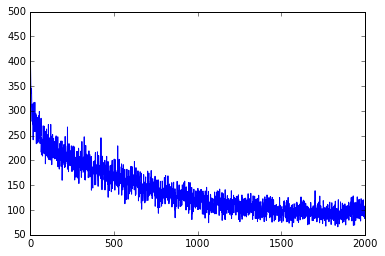

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

from atfml.core import AutoGradBackend, TheanoBackend
import atfml.utils as utils
from atfml.utils import inits, behaviours as bhvs

# bk = AutoGradBackend()
bk = TheanoBackend()

class LSTMCharModel(bk.ModelLoss):
    def __init__(self, *, vocab_size, n_hidden_dim, seq_len, data_spec):      
        self.n_hidden_dim = n_hidden_dim
        self.n_embedding_dim = n_hidden_dim
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.data_spec = data_spec
        
        w_width = self.n_embedding_dim + self.n_hidden_dim
        
        arg_dict = {
            'default_init_method': inits.gaussian_init_with(mu=0, std=1),
            'weight_template': {
                'E': {'shape':(vocab_size, self.n_embedding_dim) },
                
                'h_0': {'shape':(n_hidden_dim, ) },
                'c_0': {'shape':(n_hidden_dim, ) },
                'W_i': {'shape': (w_width, n_hidden_dim), 
                        'init_method': inits.identity_repeat_init },
                'b_i': {'shape': (n_hidden_dim, ) },
                'W_c': {'shape': (w_width, n_hidden_dim), 
                        'init_method': inits.identity_repeat_init },
                'b_c': {'shape': (n_hidden_dim, ) },
                'W_f': {'shape': (w_width, n_hidden_dim), 
                        'init_method': inits.identity_repeat_init },
                'b_f': {'shape': (n_hidden_dim, ) },
                'W_o': {'shape': (w_width, n_hidden_dim), 
                        'init_method': inits.identity_repeat_init },
                'b_o': {'shape': (n_hidden_dim, ) },
                'V_c': {'shape': (n_hidden_dim, n_hidden_dim), 
                        'init_method': inits.identity_repeat_init },
            },
            'data_template': {
                'X': {'shape':('batch_size', self.seq_len), 'dtype': 'int64' },
                'y': {'shape':('batch_size', ) , 'dtype': 'int64'},
            },
            'optimization_method': {'name': 'adam', 'learning_rate': 0.005, 'clip': 100},
            'behaviours': {
                'loss': bhvs.LossLogBehaviour(),
            }
        }
        super().__init__(**arg_dict)
    
    @bk.export_data(['X'])
    def predict(self, theta, data, const):
        """
        i_t:[batch_size, hidden_dim]
            = sigmoid( <h_{t-1}, x_t>:[batch_size, hid_dim + input_dim ] @ W_i:[hid+input, hid] + b_i[1, hid])
        c_tilde_t:[batch_size, hidden_dim]
            = tanh( <h_{t-1}, x_t>:[batch_size, hid_dim + input_dim ] @ W_c:[hid+input, hid] + b_c[1, hid])
        f_t:[batch_size, hidden_dim]
            = sigmoid( <h_{t-1}, x_t>:[batch_size, hid_dim + input_dim ] @ W_f:[hid+input, hid] + b_f[1, hid])
        c_t:[batch_size, hidden_dim]
            = i_t*c_tilde_t + f_t*c_{t-1}
        o_t:[batch_size, hidden_dim]
            = sigmoid( <h_{t-1}, x_t>:[batch_size, hid_dim + input_dim ] @ W_o:[hid+input, hid] 
                        + c_t @ V_c:[hid, hid]
                        + b_o[1, hid])
        h_t:[batch_size, hidden_dim]
            = o_t*tanh(c_t)
        
        """
        np = None # for safety
        h_prev = bk.repeat(theta.h_0[bk.newaxis, :], const.batch_size, axis=0)
        c_prev = bk.repeat(theta.c_0[bk.newaxis, :], const.batch_size, axis=0)
        
        sigmoid = lambda x: x/(1+bk.abs(x+1e-20))
        for i in range(self.seq_len):
            x_t = data.X[:, i]
            embedded_x_t = theta.E[x_t] # [batch_size, n_hidden_him]
            concat_h_x = bk.concatenate([h_prev, embedded_x_t], axis=1)
            i_t = sigmoid(bk.dot(concat_h_x, theta.W_i) + theta.b_i[bk.newaxis, :])
            c_tld_t = sigmoid(bk.dot(concat_h_x, theta.W_c) + theta.b_c[bk.newaxis, :])
            f_t = sigmoid(bk.dot(concat_h_x, theta.W_f) + theta.b_f[bk.newaxis, :])
            c_t = bk.multiply(i_t, c_tld_t) + bk.multiply(f_t, c_prev)
            o_t = sigmoid(bk.dot(concat_h_x, theta.W_o) + bk.dot(c_t, theta.V_c) 
                          + theta.b_o[bk.newaxis, :])
            h_t = bk.multiply(o_t, bk.tanh(c_t))
            h_prev = h_t
            c_prev = c_t
        
        ## [batch_size, n_hidden_dim] * [n_hidden, vocab_size]
        output_prob = bk.ops.softmax(bk.dot(h_prev, theta.E.T) )
        
        bk.assert_arr_shape({output_prob.shape: (const.batch_size, self.vocab_size)})
        return output_prob
    
    def loss(self, theta, data, const):
        np = None # for safety
        output_prob = self.raw.predict(theta, data, const)
        cross_ent_loss_i = -bk.log( output_prob[bk.arange(const.batch_size), data.y]  )
        loss = bk.sum(cross_ent_loss_i)
        return loss
    
    @bk.export
    def score(self, theta, data, const):
        np = None # for safety
        output_prob = self.raw.predict(theta, data, const)
        pred_class = bk.argmax(output_prob, axis=1)
        score = bk.sum( bk.isclose(pred_class, data.y), dtype='float32')/const.batch_size
        return score
    
    def step_callback(self, loss_val, theta, data, const, info):
        bk = None
        if info['n_iter'] % 50 == 0:
            score_val = self.compiled.score(theta, data, const)
            print('%d %10.4g %10.4g' % (info['n_iter'], loss_val, score_val))
            self.generate_output(theta, data, const, info)
            
    def generate_output(self, theta, data, const, info):
        ## print random prediction as a string
        i_to_check = np.random.randint(const.batch_size)
        data_line = data.X[i_to_check].reshape((1, -1))
        data_line_y = data.y[i_to_check].reshape((-1, ))
        original_string = prediction_into_string(data_line.ravel(), self.data_spec)

        long_pred_row = []
        for i in range(50):
            small_data = utils.to_record({'X': data_line}) # we don't care about y
            local_const = utils.to_record({'batch_size': 1}) # dirty stub :(
            output_prob = self.compiled.predict(theta, small_data, local_const)
            pred = np.argmax(output_prob, axis=1).ravel()
            new_dataline = data_line[:, 1:].ravel().tolist()+pred.tolist()
            data_line = np.array(new_dataline).reshape((1, -1))
            long_pred_row.append(pred[0])

        string = prediction_into_string(np.array(long_pred_row), self.data_spec)
        print('>>', original_string, '|', string)
            
def test_lstm_on_leo():
    data, data_spec = build_leo_tolstoy_dataset(n_data = 10000, window=30, batch_size=100)
    model = LSTMCharModel(n_hidden_dim=100, vocab_size=data_spec['charset_size'], 
                          seq_len=30, data_spec=data_spec)
    print('Charset: ', data_spec['charset_size'])
    best_theta = model.fit(data, n_max_steps=2000)
    plt.plot(model.behaviours.loss.log)
    plt.show()
    
test_lstm_on_leo()

### Implementation with unit bundles (LSTM logic is hidden):

In [8]:
%%writefile ../bundles/lstm_encoder.py

# defined in atfml/examples/Char_LSTM.ipynb
from atfml.core import UnitBundle
from atfml.utils import inits

class LSTMEncoder(UnitBundle):
    def __init__(self, bk, name, *, n_hidden_dim, n_input_dim, n_steps, masking=False):
        self.n_steps = n_steps
        w_width = n_input_dim + n_hidden_dim - int(masking) # if m then -1 dim
        self.masking = masking
        
        arg_dict = {
            'name': name,
            'weight_template': {
                'h_0': {'shape': (n_hidden_dim, ) },
                'c_0': {'shape': (n_hidden_dim, ) },
                'W_i': {'shape': (w_width, n_hidden_dim), 
                        'init_method': inits.identity_repeat_init },
                'b_i': {'shape': (n_hidden_dim, ) },
                'W_c': {'shape': (w_width, n_hidden_dim), 
                        'init_method': inits.identity_repeat_init },
                'b_c': {'shape': (n_hidden_dim, ) },
                'W_f': {'shape': (w_width, n_hidden_dim), 
                        'init_method': inits.identity_repeat_init },
                'b_f': {'shape': (n_hidden_dim, ) },
                'W_o': {'shape': (w_width, n_hidden_dim), 
                        'init_method': inits.identity_repeat_init },
                'b_o': {'shape': (n_hidden_dim, ) },
                'V_c': {'shape': (n_hidden_dim, n_hidden_dim), 
                        'init_method': inits.identity_repeat_init },
            },
            'data_template': {
                'X': ('batch_size', 'seq_len', n_input_dim),
            }
        }
        
        super().__init__(bk, **arg_dict)
        
    def _func(self, theta, data, const):
        """
            i_t:[batch_size, hidden_dim]
                = sigmoid( <h_{t-1}, x_t>:[batch_size, hid_dim + input_dim ] 
                        @ W_i:[hid+input, hid] + b_i[1, hid])
            c_tilde_t:[batch_size, hidden_dim]
                = tanh( <h_{t-1}, x_t>:[batch_size, hid_dim + input_dim ] 
                        @ W_c:[hid+input, hid] + b_c[1, hid])
            f_t:[batch_size, hidden_dim]
                = sigmoid( <h_{t-1}, x_t>:[batch_size, hid_dim + input_dim ] 
                            @ W_f:[hid+input, hid] + b_f[1, hid])
            c_t:[batch_size, hidden_dim]
                = i_t*c_tilde_t + f_t*c_{t-1}
            o_t:[batch_size, hidden_dim]
                = sigmoid( <h_{t-1}, x_t>:[batch_size, hid_dim + input_dim ] 
                            @ W_o:[hid+input, hid] 
                            + c_t @ V_c:[hid, hid] + b_o[1, hid])
            h_t:[batch_size, hidden_dim]
                = o_t*tanh(c_t)
        """
        bk = self.bk
        h_prev = self.bk.repeat(theta.h_0[bk.newaxis, :], const.batch_size, axis=0)
        c_prev = self.bk.repeat(theta.c_0[bk.newaxis, :], const.batch_size, axis=0)
        
        sigmoid = lambda x: x/(1+bk.abs(x+1e-20))
        for t in range(self.n_steps):
            x_t = data.X[:, t]
            if self.masking:
                x_t = data.X[:, t, 1:]
                mask_t = data.X[:, t, 1]
                not_mask_t = (data.X[:, t, 1] + 1) % 2
            
            concat_h_x = bk.concatenate([h_prev, x_t], axis=1)
            i_t = sigmoid(bk.dot(concat_h_x, theta.W_i) + theta.b_i[bk.newaxis, :])
            c_tld_t = sigmoid(bk.dot(concat_h_x, theta.W_c) + theta.b_c[bk.newaxis, :])
            f_t = sigmoid(bk.dot(concat_h_x, theta.W_f) + theta.b_f[bk.newaxis, :])
            c_t = bk.multiply(i_t, c_tld_t) + bk.multiply(f_t, c_prev)
            o_t = sigmoid(bk.dot(concat_h_x, theta.W_o) + bk.dot(c_t, theta.V_c) 
                          + theta.b_o[bk.newaxis, :])
            h_t = bk.multiply(o_t, bk.tanh(c_t))
            
            if self.masking:
                ## in theano sould be T.switch() - way more efficient
                h_t_masked = (bk.multiply(h_t, mask_t[:, bk.newaxis]) 
                              + bk.multiply(h_prev, not_mask_t[:, bk.newaxis]))
                h_prev = h_t_masked
            else:
                h_prev = h_t
            
            c_prev = c_t
            
        return h_prev

Overwriting ../bundles/lstm_encoder.py


In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

from atfml.core import AutoGradBackend, TheanoBackend
import atfml.utils as utils
from atfml.utils import inits, behaviours as bhvs
from atfml.bundles.lstm_encoder import LSTMEncoder

# bk = AutoGradBackend()
bk = TheanoBackend()

class LSTMCharModelWithBundles(bk.ModelLoss):
    def __init__(self, *, vocab_size, n_hidden_dim, seq_len, data_spec):      
        self.n_hidden_dim = n_hidden_dim
        self.n_embedding_dim = n_hidden_dim
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.data_spec = data_spec
        
        arg_dict = {
            'data_template': {
                'X': {'shape':('batch_size', self.seq_len), 'dtype': 'int64' },
                'y': {'shape':('batch_size', ) , 'dtype': 'int64'},
            },
            'default_init_method': inits.gaussian_init_with(mu=0, std=1),
            'weight_template': {
                'E': {'shape':(self.vocab_size, self.n_embedding_dim) },
            },
            'weight_bundles': {
                'encoder': {'class': LSTMEncoder, 
                            'args': {'n_hidden_dim':n_hidden_dim, 
                                     'n_input_dim': self.n_embedding_dim, 
                                     'n_steps': seq_len} },
                
            },
            'optimization_method': {'name': 'adam', 'learning_rate': 0.005, 'clip': 100},
            'behaviours': {
                'loss': bhvs.LossLogBehaviour(),
            }
        }
        super().__init__(**arg_dict)
    
    @bk.export_data(['X'])
    def predict(self, theta, data, const):
        np = None # for safety
        embedded_X = theta.E[data.X] # [batch_size, seq_len, n_hidden_him]
        h_last = self.bundles.encoder.apply(theta, {'X':embedded_X})
        ## [batch_size, n_hidden_dim] * [n_hidden, vocab_size]
        output_prob = bk.ops.softmax(bk.dot(h_last, theta.E.T) )
        bk.assert_arr_shape({output_prob.shape: (const.batch_size, self.vocab_size)})
        return output_prob
    
    def loss(self, theta, data, const):
        np = None # for safety
        output_prob = self.raw.predict(theta, data, const)
        cross_ent_loss_i = -bk.log( output_prob[bk.arange(const.batch_size), data.y]  )
        loss = bk.sum(cross_ent_loss_i)
        return loss
    
    @bk.export
    def score(self, theta, data, const):
        np = None # for safety
        output_prob = self.raw.predict(theta, data, const)
        pred_class = bk.argmax(output_prob, axis=1)
        score = bk.sum( bk.isclose(pred_class, data.y), dtype='float32')/const.batch_size
        return score
    
    def step_callback(self, loss_val, theta, data, const, info):
        bk = None
        if info['n_iter'] % 200 == 0:
            score_val = self.compiled.score(theta, data, const)
            print('%d %10.4g %10.4g' % (info['n_iter'], loss_val, score_val))
            self.generate_output(theta, data, const, info)
            
    def generate_output(self, theta, data, const, info):
        ## print random prediction as a string
        i_to_check = np.random.randint(const.batch_size)
        data_line = data.X[i_to_check].reshape((1, -1))
        data_line_y = data.y[i_to_check].reshape((-1, ))
        original_string = prediction_into_string(data_line.ravel(), self.data_spec)

        long_pred_row = []
        for i in range(100):
            small_data = utils.to_record({'X': data_line}) # we don't care about y
            local_const = utils.to_record({'batch_size': 1}) # dirty stub :(
            output_prob = self.compiled.predict(theta, small_data, local_const)
            pred = np.argmax(output_prob, axis=1).ravel()
            new_dataline = data_line[:, 1:].ravel().tolist()+pred.tolist()
            data_line = np.array(new_dataline).reshape((1, -1))
            long_pred_row.append(pred[0])

        string = prediction_into_string(np.array(long_pred_row), self.data_spec)
        print('>>', original_string, '|', string)

def test_lstm_on_leo():
    data, data_spec = build_leo_tolstoy_dataset(n_data = 10000, window=30, batch_size=100)
    model = LSTMCharModelWithBundles(n_hidden_dim=100, vocab_size=data_spec['charset_size'], 
                                      seq_len=30, data_spec=data_spec)
    print('Charset: ', data_spec['charset_size'])
    best_theta = model.fit(data, n_max_steps=2000)
    plt.plot(model.behaviours.loss.log)
    plt.show()
    
test_lstm_on_leo()

Weight shapes are: {'encoder__W_f': (200, 100), 'encoder__W_o': (200, 100), 'encoder__b_c': (100,), 'encoder__b_f': (100,), 'encoder__c_0': (100,), 'encoder__h_0': (100,), 'encoder__b_o': (100,), 'encoder__b_i': (100,), 'encoder__W_c': (200, 100), 'E': (70, 100), 'encoder__W_i': (200, 100), 'encoder__V_c': (100, 100)}, n_total_params: 97600
FAST_COMPILE
Building learning step function and gradient ..

### Theano Compilation time as a function of n_steps

In [11]:
import time

for seq_len in [10, 30, 50, 100]:
    for n_hidden_dim in [50, 100, 200, 400]:
        class LSTMCharModelWithBundles(bk.ModelLoss):
            def __init__(self, *, vocab_size, n_hidden_dim, seq_len, data_spec):      
                self.n_hidden_dim = n_hidden_dim
                self.n_embedding_dim = n_hidden_dim
                self.vocab_size = vocab_size
                self.seq_len = seq_len
                self.data_spec = data_spec

                arg_dict = {
                    'data_template': {
                        'X': {'shape':('batch_size', self.seq_len), 'dtype': 'int64' },
                        'y': {'shape':('batch_size', ) , 'dtype': 'int64'},
                    },
                    'default_init_method': inits.gaussian_init_with(mu=0, std=1),
                    'weight_template': {
                        'E': {'shape':(self.vocab_size, self.n_embedding_dim) },
                    },
                    'weight_bundles': {
                        'encoder': {'class': LSTMEncoder, 
                                    'args': {'n_hidden_dim':n_hidden_dim, 
                                             'n_input_dim': self.n_embedding_dim, 
                                             'n_steps': seq_len} },

                    },
                    'optimization_method': {'name': 'adam', 
                                            'learning_rate': 0.005, 
                                            'clip': 100},
                    'behaviours': {
                        'loss': bhvs.LossLogBehaviour(),
                    },
                    'verbose': False,
                }
                super().__init__(**arg_dict)

            @bk.export_data(['X'])
            def predict(self, theta, data, const):
                np = None # for safety
                embedded_X = theta.E[data.X] # [batch_size, seq_len, n_hidden_him]
                h_last = self.bundles.encoder.apply(theta, {'X':embedded_X})
                ## [batch_size, n_hidden_dim] * [n_hidden, vocab_size]
                output_prob = bk.ops.softmax(bk.dot(h_last, theta.E.T) )
                bk.assert_arr_shape({output_prob.shape: 
                                     (const.batch_size, self.vocab_size)})
                return output_prob

            def loss(self, theta, data, const):
                np = None # for safety
                output_prob = self.raw.predict(theta, data, const)
                idx = bk.arange(const.batch_size)
                cross_ent_loss_i = -bk.log( output_prob[idx, data.y]  )
                loss = bk.sum(cross_ent_loss_i)
                return loss

            def step_callback(self, loss_val, theta, data, const, info):
                pass

        now = time.clock()
        model = LSTMCharModelWithBundles(n_hidden_dim=n_hidden_dim, 
                                         vocab_size=70,
                                         seq_len=seq_len, data_spec={})
        t_diff = time.clock()
        print(seq_len, n_hidden_dim, t_diff)

10 50 8712.224641
10 100 8767.930523
10 200 8834.854101
10 400 8890.550324
30 50 9132.092808
30 100 9385.902774
30 200 9615.920387
30 400 9860.692185
50 50 10382.272901
50 100 10911.114515
50 200 11431.13315
50 400 11987.925409
100 50 13726.152938
100 100 15472.452608
100 200 17237.639376
100 400 19011.397555
